### Example  2: Heat  Equation with SNGP

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
#下面的`scipy`是一个用于科学计算和技术计算的Python库，提供了许多高级的数学函数和便利的操作，包括数值积分、插值、优化、图像处理、统计等。
import scipy.io #导入了scipy库中的io模块。scipy.io模块包含了一些用于文件输入/输出的函数，例如读取和写入.mat文件（MATLAB格式）。
from scipy.interpolate import griddata #`scipy.interpolate`是`scipy`库中的一个模块，提供了许多插值工具，用于在给定的离散数据点之间进行插值和拟合。`griddata`是这个模块中的一个函数，用于在无规则的数据点上进行插值。
from pyDOE import lhs #`pyDOE`是一个Python库，用于设计实验。它提供了一些函数来生成各种设计，如因子设计、拉丁超立方设计等。`lhs`是库中的一个函数，全名为"Latin Hypercube Sampling"，拉丁超立方采样。这是一种统计方法，用于生成一个近似均匀分布的多维样本点集。它在参数空间中生成一个非常均匀的样本，这对于高维数值优化问题非常有用，因为它可以更好地覆盖参数空间。


from mpl_toolkits.mplot3d import Axes3D #`mpl_toolkits.mplot3d`是`matplotlib`库的一个模块，用于创建三维图形。`Axes3D`是`mpl_toolkits.mplot3d`模块中的一个类，用于创建一个三维的坐标轴。可以在这个坐标轴上绘制三维的图形，如曲线、曲面等。
import time #一个内置模块，用于处理时间相关的操作。
import matplotlib.gridspec as gridspec #是`matplotlib`库的一个模块，用于创建一个网格布局来放置子图。在`matplotlib`中可以创建一个或多个子图（subplot），每个子图都有自己的坐标轴，并可以在其中绘制图形。`gridspec`模块提供了一个灵活的方式来创建和放置子图。
from mpl_toolkits.axes_grid1 import make_axes_locatable #`mpl_toolkits.axes_grid1`是`matplotlib`库的一个模块，提供了一些高级的工具来控制matplotlib图形中的坐标轴和颜色条。`make_axes_locatable`是模块中的一个函数，用于创建一个可分割的坐标轴。可以在这个坐标轴的四个方向（上、下、左、右）添加新的坐标轴或颜色条。

import math

from scipy.io import savemat #导入sys模块。sys模块提供了一些变量和函数，用于与 Python解释器进行交互和访问。例如，sys.path 是一个 Python 在导入模块时会查找的路径列表，sys.argv 是一个包含命令行参数的列表，sys.exit() 函数可以用于退出 Python 程序。导入 sys 模块后，你就可以在你的程序中使用这些变量和函数了。

np.random.seed(1234)
tf.set_random_seed(1234)

C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Dell\anaconda3\envs\SNGP_PINN\lib\site-packages\tensorf

In [2]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x0, u0, tb, X_f, layers, lb, ub, gamma  ): #这个类包含的第一个方法__init__，这是一个特殊的方法，也就是这个类的构造函数，用于初始化新创建的对象，接受了几个参数
        
        X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
        X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
        X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
        
        self.gamma =  gamma
        
        self.lb = lb
        self.ub = ub
               
        self.x0 = X0[:,0:1]
        self.t0 = X0[:,1:2]

        self.x_lb = X_lb[:,0:1]
        self.t_lb = X_lb[:,1:2]

        self.x_ub = X_ub[:,0:1]
        self.t_ub = X_ub[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.u0 = u0
                
        self.num_of_GP = 1024
        
        # Initialize NNs
        self.layers = layers
        self.weights, self.biases, self.beta,self.length_scale = self.initialize_NN(layers)
        
        # tf Placeholders        
        self.x0_tf = tf.placeholder(tf.float32, shape=[None, self.x0.shape[1]])
        self.t0_tf = tf.placeholder(tf.float32, shape=[None, self.t0.shape[1]])
        
        self.u0_tf = tf.placeholder(tf.float32, shape=[None, self.u0.shape[1]])

        
        self.x_lb_tf = tf.placeholder(tf.float32, shape=[None, self.x_lb.shape[1]])
        self.t_lb_tf = tf.placeholder(tf.float32, shape=[None, self.t_lb.shape[1]])
        
        self.x_ub_tf = tf.placeholder(tf.float32, shape=[None, self.x_ub.shape[1]])
        self.t_ub_tf = tf.placeholder(tf.float32, shape=[None, self.t_ub.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])
                
       
        self.GP_W= tf.random.normal(shape=(100,self.num_of_GP),mean =0,stddev=1,dtype=tf.float32)    #  standard normal distribution
        self.GP_W= np.sqrt(2*self.gamma)*tf.Session().run(self.GP_W)  # this is very important
        self.GP_b= tf.random.uniform(shape=(1,self.num_of_GP),minval=0,maxval=2*math.pi,dtype=tf.float32) #uniformly distributed
        self.GP_b= tf.Session().run(self.GP_b)  # this is very important
        
        # Map original data to high-dimensional space without participating in the optimization process
        self.mapping_W = tf.random_normal([2,100], stddev=1)
        self.mapping_W = tf.Session().run(self.mapping_W)/2.0
        self.mapping_b = tf.random_normal([1,100], stddev=1)
        self.mapping_b = tf.Session().run(self.mapping_b)

        # tf Graphs
        self.u0_pred , _  = self.net_u(self.x0_tf, self.t0_tf) 
        self.u_lb_pred, _ = self.net_u(self.x_lb_tf, self.t_lb_tf)
        self.u_ub_pred, _ = self.net_u(self.x_ub_tf, self.t_ub_tf)
        self.f_u_pred     = self.net_f_u(self.x_f_tf, self.t_f_tf)
                
       
        self.Hidden_pred, self.Fai_pred = self.net_for_hidden_features(self.x0_tf, self.t0_tf)
        
        # Loss
        self.loss_PDE = tf.reduce_mean(tf.square(self.u0_tf - self.u0_pred)) + \
                    tf.reduce_mean(tf.square(self.u_lb_pred)) + \
                    tf.reduce_mean(tf.square(self.u_ub_pred)) + \
                    tf.reduce_mean(tf.square(self.f_u_pred)) 
        self.loss_beta =  tf.square(tf.norm(self.beta))
        self.loss = self.loss_PDE   
        
        # Optimizers
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
    
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)
                
        # tf session
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True))
        
        init = tf.global_variables_initializer()
        self.sess.run(init)
              
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers)
        
 
        
        beta = self.xavier_init(size=[self.num_of_GP, 1])  # weights used for regression
        length_scale = tf.Variable([1.00],dtype=tf.float32)
        
        for l in range(0,num_layers-2): # The original one was -1, modified to -2 because the last layer does not need to be optimized.
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)
            
        for l in range(1,num_layers-2):   # During initialization, the norm is required to be smaller than 1.  ...
                                           #The first layer does not require regularization
            W = weights[l]           
            normalized = tf.norm(tf.transpose(W), ord=2)
            weights[l] = tf.where(tf.math.greater(normalized,0.99),0.99*W/normalized, W) #  Determine whether it is greater than the threshold       

            
        return weights, biases, beta, length_scale
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases, beta):    
        
        num_layers = len(weights) + 2  # It was originally +1, but I changed it to +2 because I initialized one less layer.
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        W = weights[0]
        b = biases[0]
        H = (tf.add(tf.matmul(H, W), b))   
        for l in range(1,num_layers-2): 
            W = weights[l]
            normalized = tf.norm(tf.transpose(W), ord=2)
            W = tf.where(tf.math.greater(normalized,0.99),0.99*W/normalized, W) # Determine whether it is greater than the threshold           
            b = biases[l]
            H1 = tf.tanh(tf.add(tf.matmul(H, W), b))
            H =tf.add(H, H1)
             
            
        H = tf.add(tf.matmul(H,self.GP_W),self.GP_b)
        H = tf.sqrt(2/self.num_of_GP)*tf.cos(H)
        Y = tf.matmul(H, beta)
        return Y
    
    def net_for_hidden_features(self,x ,t): # Find the characteristic parameters of Gaussian process
        
        weights = self.weights
        biases = self.biases
        length_scale =self.length_scale
        X = tf.concat([x,t],1)
        
        num_layers = len(weights) + 2  # It was originally +1, but I changed it to +2 because I initialized one less layer.
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        W = weights[0]
        b = biases[0]
        H =  (tf.add(tf.matmul(H, W), b))
        for l in range(1,num_layers-2): 
            W = weights[l]
            normalized = tf.norm(tf.transpose(W), ord=2)
            # Determine whether it is greater than the threshold
            W = tf.where(tf.math.greater(normalized, 0.99),0.99*W/normalized, W)  
                 
            b = biases[l]
            H1 = tf.tanh(tf.add(tf.matmul(H, W), b))
            H =tf.add(H, H1)
         
        H1 = tf.add(tf.matmul(H,self.GP_W),self.GP_b)
        Fai = tf.sqrt(2/self.num_of_GP)*tf.cos(H1)
        
        return H, Fai # Obtain the last hidden layer coordinates and random process characteristics
    
    def net_u(self, x, t):
        X = tf.concat([x,t],1)
        
        u =  self.neural_net(X, self.weights, self.biases, self.beta )
 
        
        u_x = tf.gradients(u, x)[0]

        return u, u_x

    def net_f_u(self, x, t):
        u, u_x = self.net_u(x,t)
        
        u_t = tf.gradients(u, t)[0]
        u_xx = tf.gradients(u_x, x)[0]
        mu = 1/(1*np.pi**2)
        f_u =-1*u_t + mu * u_xx 
        
        return f_u
    
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self, nIter):
        
        tf_dict = {self.x0_tf: self.x0, self.t0_tf: self.t0,
                   self.u0_tf: self.u0, 
                   self.x_lb_tf: self.x_lb, self.t_lb_tf: self.t_lb,
                   self.x_ub_tf: self.x_ub, self.t_ub_tf: self.t_ub,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_value = self.sess.run(self.loss, tf_dict)
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    def predict(self, X_star):
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        u_star = self.sess.run(self.u0_pred, tf_dict)  
 
        tf_dict = {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]}
        f_u_star = self.sess.run(self.f_u_pred, tf_dict)
        return u_star , f_u_star 

    def obtain_Hidden_and_Fai(self, X_star):
        tf_dict = {self.x0_tf: X_star[:,0:1], self.t0_tf: X_star[:,1:2]}
        Hidden_pred = self.sess.run(self.Hidden_pred, tf_dict)
        Fai_pred = self.sess.run(self.Fai_pred, tf_dict)
        return Hidden_pred, Fai_pred

In [3]:
noise = 0.0        
    
# Doman bounds
lb = np.array([-1.0, 0.0]) #  spatial time
ub = np.array([1.0, 1.0])  # spatial time

N0 = 20
N_b = 20
N_f = 200
gamma = 5.0
layers = [2,  100, 100, 100,100,1]

t = np.linspace(lb[1],ub[1],101)
t =t.flatten()[:,None]
x = np.linspace(lb[0],ub[0],101)
x =x.flatten()[:,None]
X, T = np.meshgrid(x,t)
X, T = np.meshgrid(x,t)
X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))

idx_x = np.random.choice(x.shape[0], N0, replace=False) # index to use for initial conditions
x0 = x[idx_x,:] # The value of x under initial conditions
u0 = np.sin(np.pi*x0)

idx_t = np.random.choice(t.shape[0], N_b, replace=False) # Index used for boundary conditions
tb = t[idx_t,:]   
X_f = lb + (ub-lb)*lhs(2, N_f)

data = scipy.io.loadmat('collocationpoint.mat')  

X_f = data['collocationpoint']  
x0 = X_f[0:20,0:1]
u0 = np.sin(np.pi*x0)
tb = X_f[20:40,1:2]
X_f = X_f[60:X_f.shape[0],:]  # In order to be consistent with the previous results

In [4]:
model = PhysicsInformedNN(x0, u0, tb, X_f, layers, lb, ub,gamma)

start_time = time.time()               
model.train(5000)
elapsed = time.time() - start_time                
print('Training time: %.4f' % (elapsed))   


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.


It: 0, Loss: 5.345e-01, Time: 0.97
It: 100, Loss: 3.498e-03, Time: 0.48
It: 200, Loss: 3.185e-04, Time: 0.48
It: 300, Loss: 9.575e-05, Time: 0.47
It: 400, Loss: 4.238e-05, Time: 0.47
It: 500, Loss: 2.336e-05, Time: 0.47
It: 600, Loss: 1.516e-05, Time: 0.48
It: 700, Loss: 1.257e-05, Time: 0.46
It: 800, Loss: 8.873e-06, Time: 0.47
It: 900, Loss: 3.433e-04, Time: 0.47
It: 1000, Loss: 6.615e-06, Time: 0.46
It: 1100, Loss: 5.542e-06, Time: 0.46
It: 1200, Loss: 1.741e-05, Time: 0.47
It: 1300, Loss: 4.915e-06, Time: 0.47
It: 1400, Loss: 5

Loss: 6.81163e-07
Loss: 6.795822e-07
Loss: 6.778585e-07
Loss: 6.769882e-07
Loss: 6.762921e-07
Loss: 6.754078e-07
Loss: 6.7426055e-07
Loss: 6.732279e-07
Loss: 6.724711e-07
Loss: 6.710486e-07
Loss: 6.694395e-07
Loss: 6.6683157e-07
Loss: 6.6481175e-07
Loss: 6.624184e-07
Loss: 6.5960256e-07
Loss: 6.563995e-07
Loss: 6.53449e-07
Loss: 6.5199356e-07
Loss: 6.496855e-07
Loss: 6.4706194e-07
Loss: 6.4553296e-07
Loss: 6.4326815e-07
Loss: 6.417966e-07
Loss: 6.402453e-07
Loss: 6.409351e-07
Loss: 6.392207e-07
Loss: 6.375683e-07
Loss: 6.359734e-07
Loss: 6.3370624e-07
Loss: 6.311982e-07
Loss: 6.282381e-07
Loss: 6.262774e-07
Loss: 6.238254e-07
Loss: 6.2163724e-07
Loss: 6.1981575e-07
Loss: 6.168687e-07
Loss: 6.138914e-07
Loss: 6.1139986e-07
Loss: 6.059826e-07
Loss: 6.0368075e-07
Loss: 6.0041293e-07
Loss: 5.984273e-07
Loss: 5.9648596e-07
Loss: 5.9349156e-07
Loss: 5.929445e-07
Loss: 5.912581e-07
Loss: 5.9006305e-07
Loss: 5.8834246e-07
Loss: 5.863125e-07
Loss: 5.8389253e-07
Loss: 5.819845e-07
Loss: 5.796536

In [5]:
# 训练时，所用的数据集X_know
X0 = np.concatenate((x0, 0*x0), 1) # (x0, 0)
X_lb = np.concatenate((0*tb + lb[0], tb), 1) # (lb[0], tb)
X_ub = np.concatenate((0*tb + ub[0], tb), 1) # (ub[0], tb)
X_know = np.concatenate((X0, X_lb, X_ub, X_f),0) # X_know the corresponding predicted value
u_pred, f_u_pred = model.predict(X_know)
f_know = u_pred

In [6]:
u_pred, f_u_pred = model.predict(X_star)
prediction_all = u_pred

In [8]:
# Hidden layer of X_konw
Hidden_pred_small, Fai_pred_small = model.obtain_Hidden_and_Fai(X_know)
X = Hidden_pred_small
hidden_feat_know = Fai_pred_small

In [9]:
#Hidden layer for new data
Hidden_pred_all, Fai_pred_all = model.obtain_Hidden_and_Fai(X_star)
X_xing = Hidden_pred_all
hidden_feat_all = Fai_pred_all

In [10]:
n_xing = X_xing.shape[0]
Cov_xing_xing = np.zeros(shape=(n_xing, n_xing), dtype=float)
for i in range(n_xing):
    for j in range(n_xing):
        xi = X_xing[i:i+1,:]
        xj = X_xing[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_xing[i][j] = np.exp(-gamma*dij)

In [12]:
n = X.shape[0]
Cov_X_X = np.zeros(shape=(n, n), dtype=float)
for i in range(n):
    for j in range(n):
        xi = X[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_X_X[i][j] = np.exp(-gamma*dij)

In [13]:
Cov_xing_X = np.zeros(shape=(n_xing, n), dtype=float)
for i in range(n_xing):
    for j in range(n):
        xi = X_xing[i:i+1,:]
        xj = X[j:j+1,:]
        dij = np.sum((xi-xj)**2)
        Cov_xing_X[i][j] = np.exp(-gamma*dij)

In [14]:
Cov_X_xing = Cov_xing_X.T

In [15]:
rho_orig = Cov_X_X
xishu = 100000000
rho = rho_orig*xishu 
u, s, v = np.linalg.svd(rho)
inv_s=np.linalg.inv(np.diag(s))
t1= np.matmul(v.T, inv_s) 
t2= np.matmul(t1, u.T)
t3= np.matmul(t2, rho) # Check whether the obtained inverse matrix is correct. If it is the identity matrix, it means there is no problem.
inv_rho = t2*xishu  # Inverse of covariance matrix

In [16]:
sigma_2= Cov_xing_xing - np.matmul(np.matmul(Cov_xing_X, inv_rho), Cov_X_xing)

In [17]:
sigma_2 = np.diag(sigma_2)
sigma_2 = np.abs(sigma_2)
sigma = np.sqrt(sigma_2)
sigma = sigma[:, np.newaxis]

In [18]:
# reall value
reall_all = np.sin(np.pi*X_star[:,0:1])*np.exp(-X_star[:,1:2])
# Predictive value
prediction_all = u_pred

In [19]:
Sigma = sigma

In [20]:
#The set of loc values is: 0 25 50 100++.
loc = 100;  
loc_index= loc*101 + np.arange(1, 102);
loc_index = loc_index -1 

x_t = np.linspace(-1, 1, 101);

In [21]:
reall = reall_all[loc_index]
prediction = prediction_all[loc_index]

In [22]:
sigma = Sigma[loc_index]

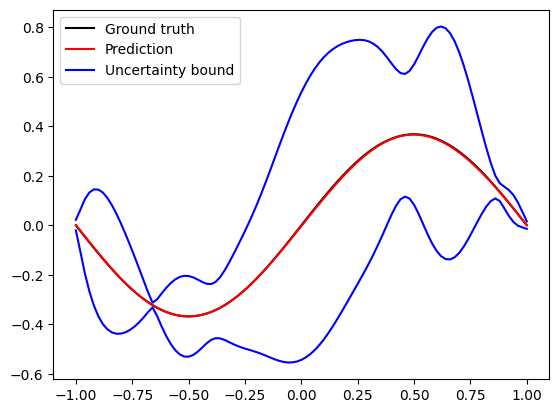

In [23]:
# plot
plt.style.use('default')
plt.figure()

plt.plot(x_t,reall,'k')
plt.plot(x_t,prediction,'r')
plt.plot(x_t,prediction+3*sigma,'b')


plt.legend(['Ground truth','Prediction','Uncertainty bound'], loc = 'best') 
plt.plot(x_t, prediction-3*sigma, 'b')